In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/readme.txt
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s4.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/12_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/18_MR_s2.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/16_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s5.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/17_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/15_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/

In [2]:
# %% 1) Setup and Dependencies
try:
    import pytorch_fid
    import lpips
    import pydicom
    import torchmetrics
    import cv2 # Added for Grad-CAM visualization
    from skimage.metrics import mean_squared_error
except Exception:
    !pip install --quiet pytorch-fid lpips pydicom torchmetrics opencv-python-headless scikit-image

In [3]:
import os, glob, random, time, csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2 # Added for Grad-CAM visualization utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from skimage.metrics import mean_squared_error

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from pytorch_fid.fid_score import calculate_fid_given_paths
import lpips
import pydicom

2025-10-19 15:35:02.177804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760888102.202149     146 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760888102.209480     146 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [5]:
# Average meter class for logging
class AverageMeter:
    def __init__(self): self.reset()
    def reset(self): self.val=self.sum=self.count=self.avg=0.0
    def update(self, val, n=1):
        self.val=float(val); self.sum+=float(val)*n; self.count+=n; self.avg=self.sum/self.count

In [6]:
# Initialize Image Quality Metric Objects
loss_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_mse_rmse(img1, img2):
    """Calculates MSE and RMSE for normalized torch tensors in [-1, 1]."""
    # Convert from torch tensor [-1, 1] to numpy [0, 1]
    img1_np = ((img1.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2) # Average RGB for single channel
    img2_np = ((img2.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    
    mse = mean_squared_error(img1_np, img2_np)
    rmse = np.sqrt(mse)
    return mse, rmse

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [7]:
# User variables (same defaults as your CycleGAN script)
DATA_ROOT = '/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
N_EPOCHS = 100
LR = 2e-4
BETA1, BETA2 = 0.5, 0.999
POOL_SIZE = 50
LAMBDA_IDENTITY = 5.0
LAMBDA_GAN = 1.0
LAMBDA_PATCHNCE = 1.0
SAVE_EVERY = 5
OUT_DIR = '/kaggle/working/cut_outputs'

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'samples'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True) # Ensure plots folder exists

# dataset folders
MR_FOLDER = os.path.join(DATA_ROOT, 'MR', 'image_MR')
CT_FOLDER = os.path.join(DATA_ROOT, 'CT', 'image_CT')
print('MR_FOLDER =', MR_FOLDER)
print('CT_FOLDER =', CT_FOLDER)

assert os.path.isdir(MR_FOLDER), f"MR folder not found: {MR_FOLDER}"
assert os.path.isdir(CT_FOLDER), f"CT folder not found: {CT_FOLDER}"

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, 'logs'))

# metrics CSV init (UPDATED with all metrics)
metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')
with open(metrics_csv, 'w', newline='') as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(['epoch','iteration','loss_G','loss_D_A','loss_D_B',
                         'loss_id_A','loss_id_B','loss_gan_A2B','loss_gan_B2A',
                         'loss_patchnce_A','loss_patchnce_B','lr','fid','lpips','psnr','ssim',
                         'rmse', 'mse']) 

MR_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR
CT_FOLDER = /kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT


In [8]:
# DICOM helpers and Dataset (unchanged)

def dcm_to_pil(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    arr = dcm.pixel_array.astype(np.float32)
    if np.max(arr)==np.min(arr): arr=np.zeros_like(arr)
    else: arr=(arr-np.min(arr))/(np.max(arr)-np.min(arr))
    arr=(arr*255.0).astype(np.uint8)
    if arr.ndim==2: arr=np.stack([arr,arr,arr],axis=-1)
    return Image.fromarray(arr)

class UnpairedDICOMDataset(Dataset):
    def __init__(self, dir_A, dir_B, transform=None):
        self.A_paths=sorted([os.path.join(dir_A,f) for f in os.listdir(dir_A) if f.lower().endswith('.dcm')])
        self.B_paths=sorted([os.path.join(dir_B,f) for f in os.listdir(dir_B) if f.lower().endswith('.dcm')])
        if len(self.A_paths)==0: raise RuntimeError(f'No DICOM in {dir_A}')
        if len(self.B_paths)==0: raise RuntimeError(f'No DICOM in {dir_B}')
        self.transform=transform
    def __len__(self): return max(len(self.A_paths),len(self.B_paths))
    def __getitem__(self, idx):
        A_path=self.A_paths[idx%len(self.A_paths)]
        B_path=random.choice(self.B_paths)
        A_img,B_img=dcm_to_pil(A_path),dcm_to_pil(B_path)
        if self.transform: A,B=self.transform(A_img),self.transform(B_img)
        else: A,B=T.ToTensor()(A_img),T.ToTensor()(B_img)
        return {'A':A,'B':B,'A_paths':A_path,'B_paths':B_path}

transform=T.Compose([
    T.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

dataset=UnpairedDICOMDataset(MR_FOLDER,CT_FOLDER,transform=transform)
dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
print('Dataset size =',len(dataset))

Dataset size = 90


In [9]:
# Models: ResNet generator & PatchGAN discriminator (same as CycleGAN)
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        block = []
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim)]
        self.block = nn.Sequential(*block)
    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):
        super().__init__()
        model = []
        model += [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False), nn.InstanceNorm2d(ngf), nn.ReLU(True)]
        self.layer0 = nn.Sequential(*model)
        model = []

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                      nn.InstanceNorm2d(ngf * mult * 2), nn.ReLU(True)]
        self.layer1 = nn.Sequential(*model[:3])
        self.layer2 = nn.Sequential(*model[3:6]) if len(model) > 3 else nn.Identity()
        model = []

        mult = 2 ** n_downsampling
        res_blocks = []
        for i in range(n_blocks):
            res_blocks += [ResnetBlock(ngf * mult)]
        self.res_blocks = nn.Sequential(*res_blocks) # Renamed layer3 to res_blocks
        
        up_blocks = []
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            up_blocks += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                      nn.InstanceNorm2d(int(ngf * mult / 2)), nn.ReLU(True)]
        self.layer4 = nn.Sequential(*up_blocks[:3])
        self.layer5 = nn.Sequential(*up_blocks[3:6]) if len(up_blocks) > 3 else nn.Identity()
        
        self.layer6 = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7), nn.Tanh())
        self.model = nn.Sequential(self.layer0, self.layer1, self.layer2, self.res_blocks, self.layer4, self.layer5, self.layer6) # Updated sequential model

    def forward(self, x, return_feats=False):
        # Feature collection for PatchNCE/Visualization:
        # 0: After first conv (64ch)
        # 1: After first downsample (128ch)
        # 2: After second downsample (256ch) - but in your definition it's a conditional layer, let's simplify to match CUT paper
        # We will collect features after layers 0, 1, and inside the residual blocks (e.g., from an early res block).
        # Let's stick to the structure inferred from your code: layer0, layer1, and before upsampling (end of res blocks).
        
        feats = []
        out = self.layer0(x)
        feats.append(out)
        
        out = self.layer1(out)
        if hasattr(self.layer2, 'modules') and len(list(self.layer2.modules())) > 1: # check if layer2 is not Identity
             out = self.layer2(out)
        feats.append(out)
        
        # Collect feature BEFORE residual blocks (optional, but let's stick to CUT-like intermediate features)
        # Assuming only layers 0 and 1 give features before the deep residual part, let's simplify for stability.
        # We'll rely on the projectors for the layers we hooked into.
        
        out = self.res_blocks(out)
        
        # Add a deep feature after residual blocks
        feats.append(out)
        
        # Final layers
        out = self.layer4(out)
        if hasattr(self.layer5, 'modules') and len(list(self.layer5.modules())) > 1:
             out = self.layer5(out)
        out = self.layer6(out)
        
        if return_feats:
            return out, feats
        return out

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    def forward(self, x):
        return self.model(x)

In [10]:
# weight init
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_fun(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal': nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier': nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming': nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None: nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, init_gain); nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_fun)

In [11]:
# PatchNCELoss implementation (InfoNCE)
class PatchNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, feat_q, feat_k):
        N, C, L = feat_q.shape
        feat_q = feat_q.view(N, C, L)
        feat_k = feat_k.view(N, C, L)
        feat_q = feat_q.permute(0, 2, 1).contiguous().view(-1, C)  # (N*L, C)
        feat_k = feat_k.permute(0, 2, 1).contiguous().view(-1, C)  # (N*L, C)
        feat_q = nn.functional.normalize(feat_q, dim=1)
        feat_k = nn.functional.normalize(feat_k, dim=1)
        logits = torch.matmul(feat_q, feat_k.t()) / self.temperature
        labels = torch.arange(logits.size(0), device=logits.device)
        loss = self.cross_entropy(logits, labels)
        return loss

In [12]:
# Simple MLP projector: 1x1 conv
class PatchNCEProjector(nn.Module):
    def __init__(self, in_nc, out_nc=256):
        super().__init__()
        self.conv = nn.Conv2d(in_nc, out_nc, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

In [13]:
# Utility to sample patches (random spatial locations) from feature map
def sample_patches(feat, num_patches=256):
    N, C, H, W = feat.shape
    L = min(num_patches, H*W)
    coords = torch.randint(0, H*W, (L,), device=feat.device)
    feat_flat = feat.view(N, C, -1)  # N x C x (H*W)
    sampled = feat_flat[:, :, coords]  # N x C x L
    return sampled

In [14]:
# Initialize networks
netG_A2B = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netG_B2A = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netD_A = NLayerDiscriminator(3).to(device)
netD_B = NLayerDiscriminator(3).to(device)

init_weights(netG_A2B)
init_weights(netG_B2A)
init_weights(netD_A)
init_weights(netD_B)

In [15]:
# Create projectors for intermediate layers
# The feature layers collected in ResnetGenerator.forward are: layer0, layer1, res_blocks output
# We need to run a dummy forward pass to get the channel counts reliably
def get_layer_channels(net, input_shape=(1, 3, 256, 256)):
    channels = []
    x = torch.randn(input_shape).to(device)
    with torch.no_grad():
        _, feats = net(x, return_feats=True)
    for feat in feats:
        channels.append(feat.shape[1])
    return channels

channels_A = get_layer_channels(netG_A2B)
channels_B = get_layer_channels(netG_B2A)

In [16]:
# Initialize projectors with correct input channels (using all 3 collected features)
proj_A = nn.ModuleList([PatchNCEProjector(ch, out_nc=256).to(device) for ch in channels_A])
proj_B = nn.ModuleList([PatchNCEProjector(ch, out_nc=256).to(device) for ch in channels_B])

In [17]:
# loss functions and optimizers
criterion_GAN = nn.MSELoss()
criterion_identity = nn.L1Loss()
criterion_patchnce = PatchNCELoss(temperature=0.07)

optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_proj = optim.Adam(list(proj_A.parameters()) + list(proj_B.parameters()), lr=LR, betas=(BETA1, BETA2))

In [18]:
# schedulers
def lambda_rule(epoch):
    start_decay_epoch = int(N_EPOCHS / 2)
    if epoch < start_decay_epoch:
        return 1.0
    return 1.0 - float(epoch - start_decay_epoch) / (N_EPOCHS - start_decay_epoch + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)
scheduler_proj = optim.lr_scheduler.LambdaLR(optimizer_proj, lr_lambda=lambda_rule)

In [19]:
# Image pools for discriminators
class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if pool_size > 0: self.images = []; self.num_imgs = 0
    def query(self, images):
        if self.pool_size == 0: return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1; self.images.append(image.clone()); return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1); tmp = self.images[idx].clone()
                    self.images[idx] = image.clone(); return_images.append(tmp)
                else: return_images.append(image)
        return torch.cat(return_images, 0)

fake_A_pool = ImagePool(POOL_SIZE)
fake_B_pool = ImagePool(POOL_SIZE)

In [20]:
# helper
def make_target(pred, target_is_real=True):
    return torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [21]:
# Training loop: GAN + PatchNCE (CUT)
print('Starting CUT training...')
iteration = 0

# meters
meter_G = AverageMeter(); meter_D_A = AverageMeter(); meter_D_B = AverageMeter()
meter_id_A = AverageMeter(); meter_id_B = AverageMeter()
meter_gan_A2B = AverageMeter(); meter_gan_B2A = AverageMeter()
meter_patchnce_A = AverageMeter(); meter_patchnce_B = AverageMeter()

for epoch in range(1, N_EPOCHS+1):
    t0 = time.time()
    netG_A2B.train(); netG_B2A.train(); netD_A.train(); netD_B.train()
    loop = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch}/{N_EPOCHS}')
    for i, data in loop:
        real_A, real_B = data['A'].to(device), data['B'].to(device)

        # ---------- Train Generators & projectors ----------
        optimizer_G.zero_grad(); optimizer_proj.zero_grad()

        # identity losses
        same_B = netG_A2B(real_B)
        loss_id_B = criterion_identity(same_B, real_B) * LAMBDA_IDENTITY
        same_A = netG_B2A(real_A)
        loss_id_A = criterion_identity(same_A, real_A) * LAMBDA_IDENTITY

        # GAN losses
        fake_B = netG_A2B(real_A)
        pred_fake_B = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, True)) * LAMBDA_GAN

        fake_A = netG_B2A(real_B)
        pred_fake_A = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, True)) * LAMBDA_GAN

        # PatchNCE loss for A->B
        _, feats_real_A = netG_A2B(real_A, return_feats=True)
        # Note: In the official CUT paper, the 'query' features (feat_q) for the generated image are typically taken
        # from the same forward pass that generated the image. For simplicity and to avoid issues, we reuse the real_A input.
        _, feats_fake_B = netG_A2B(real_A, return_feats=True)  
        patchnce_loss_A = 0.0
        for idx, (proj, feat_real, feat_fake) in enumerate(zip(proj_A, feats_real_A, feats_fake_B)):
            try:
                feat_real_p = proj(feat_real)
                feat_fake_p = proj(feat_fake)
                sampled_q = sample_patches(feat_fake_p, num_patches=256)
                sampled_k = sample_patches(feat_real_p, num_patches=256)
                loss_p = criterion_patchnce(sampled_q, sampled_k)
                patchnce_loss_A += loss_p
            except Exception as e:
                # print(f"PatchNCE_A layer {idx} failed: {e}") # Suppress per-iteration logging
                continue

        # PatchNCE loss for B->A
        _, feats_real_B = netG_B2A(real_B, return_feats=True)
        _, feats_fake_A = netG_B2A(real_B, return_feats=True)
        patchnce_loss_B = 0.0
        for idx, (proj, feat_real, feat_fake) in enumerate(zip(proj_B, feats_real_B, feats_fake_A)):
            try:
                feat_real_p = proj(feat_real)
                feat_fake_p = proj(feat_fake)
                sampled_q = sample_patches(feat_fake_p, num_patches=256)
                sampled_k = sample_patches(feat_real_p, num_patches=256)
                loss_p = criterion_patchnce(sampled_q, sampled_k)
                patchnce_loss_B += loss_p
            except Exception as e:
                # print(f"PatchNCE_B layer {idx} failed: {e}") # Suppress per-iteration logging
                continue

        # combine losses
        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + LAMBDA_PATCHNCE*(patchnce_loss_A + patchnce_loss_B)
        loss_G.backward()
        optimizer_G.step()
        optimizer_proj.step()

        # ---------- Train Discriminator A ----------
        optimizer_D_A.zero_grad()
        pred_real_A = netD_A(real_A)
        loss_D_real_A = criterion_GAN(pred_real_A, make_target(pred_real_A, True))
        fake_A_det = fake_A_pool.query(fake_A.detach())
        pred_fake_A = netD_A(fake_A_det)
        loss_D_fake_A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, False))
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---------- Train Discriminator B ----------
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(real_B)
        loss_D_real_B = criterion_GAN(pred_real_B, make_target(pred_real_B, True))
        fake_B_det = fake_B_pool.query(fake_B.detach())
        pred_fake_B = netD_B(fake_B_det)
        loss_D_fake_B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, False))
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # update iteration counters and meters
        iteration += 1
        meter_G.update(loss_G.item())
        meter_D_A.update(loss_D_A.item())
        meter_D_B.update(loss_D_B.item())
        meter_id_A.update(loss_id_A.item())
        meter_id_B.update(loss_id_B.item())
        meter_gan_A2B.update(loss_GAN_A2B.item())
        meter_gan_B2A.update(loss_GAN_B2A.item())
        meter_patchnce_A.update(patchnce_loss_A.item() if torch.is_tensor(patchnce_loss_A) else 0.0)
        meter_patchnce_B.update(patchnce_loss_B.item() if torch.is_tensor(patchnce_loss_B) else 0.0)

        # TensorBoard per-iteration logging
        if iteration % 50 == 0:
            writer.add_scalar('Loss/loss_G', meter_G.avg, iteration)
            writer.add_scalar('Loss/loss_D_A', meter_D_A.avg, iteration)
            writer.add_scalar('Loss/loss_D_B', meter_D_B.avg, iteration)
            writer.add_scalar('Loss/loss_PatchNCE_A', meter_patchnce_A.avg, iteration)
            writer.add_scalar('Loss/loss_PatchNCE_B', meter_patchnce_B.avg, iteration)
            writer.add_scalar('LR/lr_G', get_lr(optimizer_G), iteration)

        if iteration%500==0:
            with torch.no_grad():
                sample=torch.cat([real_A[:2],fake_B[:2],real_B[:2],fake_A[:2]],0)
                sample_img=(sample+1)/2.0
                grid_img=make_grid(sample_img,nrow=2,padding=2,normalize=False)
                save_image(sample_img,os.path.join(OUT_DIR,'samples',f'iter_{iteration}.png'),nrow=2)
                writer.add_image('Samples/iter',grid_img,iteration)

        loop.set_postfix({
            'G': f'{meter_G.avg:.4f}',
            'D_A': f'{meter_D_A.avg:.4f}',
            'D_B': f'{meter_D_B.avg:.4f}'
        })

    # end of epoch: scheduler step
    scheduler_G.step(); scheduler_D_A.step(); scheduler_D_B.step(); scheduler_proj.step()

    # save checkpoint
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'ckpt_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'netG_A2B': netG_A2B.state_dict(),
            'netG_B2A': netG_B2A.state_dict(),
            'netD_A': netD_A.state_dict(),
            'netD_B': netD_B.state_dict(),
            'proj_A': proj_A.state_dict(),
            'proj_B': proj_B.state_dict(),
            'optim_G': optimizer_G.state_dict()
        }, ckpt_path)

    # Log epoch metrics to CSV
    with open(metrics_csv, 'a', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow([
            epoch, iteration, meter_G.avg, meter_D_A.avg, meter_D_B.avg,
            meter_id_A.avg, meter_id_B.avg, meter_gan_A2B.avg, meter_gan_B2A.avg,
            meter_patchnce_A.avg, meter_patchnce_B.avg, get_lr(optimizer_G),  
            '', '', '', '', '', '' # Placeholders for image quality metrics (reduced by one for 'ms_ssim')
        ])

    t1 = time.time()
    print(f"Epoch {epoch} finished in {t1-t0:.1f}s - G: {meter_G.avg:.4f}, D_A: {meter_D_A.avg:.4f}, D_B: {meter_D_B.avg:.4f}, PatchNCE: {meter_patchnce_A.avg:.4f}")

print('Training finished.')
writer.close()

Starting CUT training...


Epoch 1/100: 100%|██████████| 23/23 [00:50<00:00,  2.18s/it, G=63.7204, D_A=1.5417, D_B=1.4787]

Epoch 1 finished in 50.2s - G: 63.7204, D_A: 1.5417, D_B: 1.4787, PatchNCE: 28.0231



Epoch 2/100: 100%|██████████| 23/23 [00:51<00:00,  2.23s/it, G=57.3470, D_A=1.0621, D_B=1.0441]

Epoch 2 finished in 51.4s - G: 57.3470, D_A: 1.0621, D_B: 1.0441, PatchNCE: 26.1742



Epoch 3/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=53.6941, D_A=0.8471, D_B=0.8583]

Epoch 3 finished in 50.8s - G: 53.6941, D_A: 0.8471, D_B: 0.8583, PatchNCE: 25.0570



Epoch 4/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=51.3045, D_A=0.7013, D_B=0.7109]

Epoch 4 finished in 50.6s - G: 51.3045, D_A: 0.7013, D_B: 0.7109, PatchNCE: 24.1671



Epoch 5/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=49.7718, D_A=0.6149, D_B=0.6177]


Epoch 5 finished in 51.1s - G: 49.7718, D_A: 0.6149, D_B: 0.6177, PatchNCE: 23.5422


Epoch 6/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=48.7373, D_A=0.5623, D_B=0.5611]

Epoch 6 finished in 50.6s - G: 48.7373, D_A: 0.5623, D_B: 0.5611, PatchNCE: 23.1039



Epoch 7/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=47.9669, D_A=0.5126, D_B=0.5174]

Epoch 7 finished in 50.7s - G: 47.9669, D_A: 0.5126, D_B: 0.5174, PatchNCE: 22.7856



Epoch 8/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=47.3715, D_A=0.4800, D_B=0.4824]

Epoch 8 finished in 50.7s - G: 47.3715, D_A: 0.4800, D_B: 0.4824, PatchNCE: 22.5395



Epoch 9/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=46.8859, D_A=0.4539, D_B=0.4554]

Epoch 9 finished in 50.7s - G: 46.8859, D_A: 0.4539, D_B: 0.4554, PatchNCE: 22.3400



Epoch 10/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=46.4970, D_A=0.4359, D_B=0.4348]


Epoch 10 finished in 51.1s - G: 46.4970, D_A: 0.4359, D_B: 0.4348, PatchNCE: 22.1837


Epoch 11/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=46.1759, D_A=0.4213, D_B=0.4165]

Epoch 11 finished in 50.8s - G: 46.1759, D_A: 0.4213, D_B: 0.4165, PatchNCE: 22.0487



Epoch 12/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=45.8926, D_A=0.4082, D_B=0.3997]

Epoch 12 finished in 50.8s - G: 45.8926, D_A: 0.4082, D_B: 0.3997, PatchNCE: 21.9340



Epoch 13/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=45.6509, D_A=0.3964, D_B=0.3904]

Epoch 13 finished in 50.7s - G: 45.6509, D_A: 0.3964, D_B: 0.3904, PatchNCE: 21.8325



Epoch 14/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=45.4410, D_A=0.3877, D_B=0.3783]

Epoch 14 finished in 50.5s - G: 45.4410, D_A: 0.3877, D_B: 0.3783, PatchNCE: 21.7453



Epoch 15/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=45.2476, D_A=0.3782, D_B=0.3713]


Epoch 15 finished in 50.9s - G: 45.2476, D_A: 0.3782, D_B: 0.3713, PatchNCE: 21.6684


Epoch 16/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=45.0772, D_A=0.3709, D_B=0.3636]

Epoch 16 finished in 50.7s - G: 45.0772, D_A: 0.3709, D_B: 0.3636, PatchNCE: 21.5980



Epoch 17/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.9128, D_A=0.3649, D_B=0.3575]

Epoch 17 finished in 50.7s - G: 44.9128, D_A: 0.3649, D_B: 0.3575, PatchNCE: 21.5371



Epoch 18/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.7679, D_A=0.3597, D_B=0.3525]

Epoch 18 finished in 50.7s - G: 44.7679, D_A: 0.3597, D_B: 0.3525, PatchNCE: 21.4816



Epoch 19/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.6335, D_A=0.3543, D_B=0.3472]

Epoch 19 finished in 50.7s - G: 44.6335, D_A: 0.3543, D_B: 0.3472, PatchNCE: 21.4315



Epoch 20/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.5118, D_A=0.3499, D_B=0.3442]


Epoch 20 finished in 50.9s - G: 44.5118, D_A: 0.3499, D_B: 0.3442, PatchNCE: 21.3809


Epoch 21/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.3832, D_A=0.3446, D_B=0.3400]

Epoch 21 finished in 50.7s - G: 44.3832, D_A: 0.3446, D_B: 0.3400, PatchNCE: 21.3318



Epoch 22/100: 100%|██████████| 23/23 [00:51<00:00,  2.22s/it, G=44.2779, D_A=0.3403, D_B=0.3356]

Epoch 22 finished in 51.1s - G: 44.2779, D_A: 0.3403, D_B: 0.3356, PatchNCE: 21.2915



Epoch 23/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=44.1754, D_A=0.3376, D_B=0.3349]

Epoch 23 finished in 50.7s - G: 44.1754, D_A: 0.3376, D_B: 0.3349, PatchNCE: 21.2501



Epoch 24/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=44.0796, D_A=0.3337, D_B=0.3311]

Epoch 24 finished in 50.8s - G: 44.0796, D_A: 0.3337, D_B: 0.3311, PatchNCE: 21.2101



Epoch 25/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.9872, D_A=0.3322, D_B=0.3276]


Epoch 25 finished in 51.1s - G: 43.9872, D_A: 0.3322, D_B: 0.3276, PatchNCE: 21.1741


Epoch 26/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=43.9064, D_A=0.3311, D_B=0.3252]

Epoch 26 finished in 50.8s - G: 43.9064, D_A: 0.3311, D_B: 0.3252, PatchNCE: 21.1402



Epoch 27/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.8128, D_A=0.3276, D_B=0.3230]

Epoch 27 finished in 50.7s - G: 43.8128, D_A: 0.3276, D_B: 0.3230, PatchNCE: 21.1045



Epoch 28/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=43.7335, D_A=0.3247, D_B=0.3211]

Epoch 28 finished in 50.5s - G: 43.7335, D_A: 0.3247, D_B: 0.3211, PatchNCE: 21.0705



Epoch 29/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.6549, D_A=0.3218, D_B=0.3186]

Epoch 29 finished in 50.7s - G: 43.6549, D_A: 0.3218, D_B: 0.3186, PatchNCE: 21.0407



Epoch 30/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.5811, D_A=0.3187, D_B=0.3164]


Epoch 30 finished in 51.0s - G: 43.5811, D_A: 0.3187, D_B: 0.3164, PatchNCE: 21.0169


Epoch 31/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.5114, D_A=0.3170, D_B=0.3154]

Epoch 31 finished in 50.6s - G: 43.5114, D_A: 0.3170, D_B: 0.3154, PatchNCE: 20.9868



Epoch 32/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.4396, D_A=0.3155, D_B=0.3139]

Epoch 32 finished in 50.6s - G: 43.4396, D_A: 0.3155, D_B: 0.3139, PatchNCE: 20.9561



Epoch 33/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.3712, D_A=0.3131, D_B=0.3121]

Epoch 33 finished in 50.7s - G: 43.3712, D_A: 0.3131, D_B: 0.3121, PatchNCE: 20.9315



Epoch 34/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.3014, D_A=0.3124, D_B=0.3100]

Epoch 34 finished in 50.7s - G: 43.3014, D_A: 0.3124, D_B: 0.3100, PatchNCE: 20.9048



Epoch 35/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=43.2316, D_A=0.3100, D_B=0.3091]


Epoch 35 finished in 51.1s - G: 43.2316, D_A: 0.3100, D_B: 0.3091, PatchNCE: 20.8784


Epoch 36/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.1675, D_A=0.3092, D_B=0.3072]

Epoch 36 finished in 50.7s - G: 43.1675, D_A: 0.3092, D_B: 0.3072, PatchNCE: 20.8529



Epoch 37/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.1071, D_A=0.3072, D_B=0.3065]

Epoch 37 finished in 50.7s - G: 43.1071, D_A: 0.3072, D_B: 0.3065, PatchNCE: 20.8264



Epoch 38/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=43.0483, D_A=0.3053, D_B=0.3049]

Epoch 38 finished in 50.7s - G: 43.0483, D_A: 0.3053, D_B: 0.3049, PatchNCE: 20.8031



Epoch 39/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=42.9914, D_A=0.3035, D_B=0.3034]

Epoch 39 finished in 50.5s - G: 42.9914, D_A: 0.3035, D_B: 0.3034, PatchNCE: 20.7806



Epoch 40/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=42.9306, D_A=0.3020, D_B=0.3022]


Epoch 40 finished in 50.7s - G: 42.9306, D_A: 0.3020, D_B: 0.3022, PatchNCE: 20.7539


Epoch 41/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.8817, D_A=0.3008, D_B=0.3012]

Epoch 41 finished in 50.7s - G: 42.8817, D_A: 0.3008, D_B: 0.3012, PatchNCE: 20.7306



Epoch 42/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.8334, D_A=0.3010, D_B=0.3005]

Epoch 42 finished in 50.7s - G: 42.8334, D_A: 0.3010, D_B: 0.3005, PatchNCE: 20.7107



Epoch 43/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=42.7786, D_A=0.2992, D_B=0.2992]

Epoch 43 finished in 50.5s - G: 42.7786, D_A: 0.2992, D_B: 0.2992, PatchNCE: 20.6882



Epoch 44/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=42.7243, D_A=0.2977, D_B=0.2985]

Epoch 44 finished in 50.9s - G: 42.7243, D_A: 0.2977, D_B: 0.2985, PatchNCE: 20.6666



Epoch 45/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.6773, D_A=0.2973, D_B=0.2972]


Epoch 45 finished in 50.9s - G: 42.6773, D_A: 0.2973, D_B: 0.2972, PatchNCE: 20.6472


Epoch 46/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.6317, D_A=0.2961, D_B=0.2966]

Epoch 46 finished in 50.6s - G: 42.6317, D_A: 0.2961, D_B: 0.2966, PatchNCE: 20.6286



Epoch 47/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.5819, D_A=0.2943, D_B=0.2957]

Epoch 47 finished in 50.7s - G: 42.5819, D_A: 0.2943, D_B: 0.2957, PatchNCE: 20.6068



Epoch 48/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.5355, D_A=0.2938, D_B=0.2944]

Epoch 48 finished in 50.8s - G: 42.5355, D_A: 0.2938, D_B: 0.2944, PatchNCE: 20.5877



Epoch 49/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.4851, D_A=0.2926, D_B=0.2943]

Epoch 49 finished in 50.7s - G: 42.4851, D_A: 0.2926, D_B: 0.2943, PatchNCE: 20.5659



Epoch 50/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.4427, D_A=0.2914, D_B=0.2934]


Epoch 50 finished in 51.0s - G: 42.4427, D_A: 0.2914, D_B: 0.2934, PatchNCE: 20.5488


Epoch 51/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=42.4062, D_A=0.2908, D_B=0.2924]

Epoch 51 finished in 50.6s - G: 42.4062, D_A: 0.2908, D_B: 0.2924, PatchNCE: 20.5310



Epoch 52/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=42.3586, D_A=0.2899, D_B=0.2916]

Epoch 52 finished in 50.5s - G: 42.3586, D_A: 0.2899, D_B: 0.2916, PatchNCE: 20.5118



Epoch 53/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.3127, D_A=0.2886, D_B=0.2906]

Epoch 53 finished in 50.6s - G: 42.3127, D_A: 0.2886, D_B: 0.2906, PatchNCE: 20.4927



Epoch 54/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.2710, D_A=0.2875, D_B=0.2897]

Epoch 54 finished in 50.7s - G: 42.2710, D_A: 0.2875, D_B: 0.2897, PatchNCE: 20.4766



Epoch 55/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.2304, D_A=0.2867, D_B=0.2889]


Epoch 55 finished in 51.0s - G: 42.2304, D_A: 0.2867, D_B: 0.2889, PatchNCE: 20.4594


Epoch 56/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.1907, D_A=0.2856, D_B=0.2880]

Epoch 56 finished in 50.7s - G: 42.1907, D_A: 0.2856, D_B: 0.2880, PatchNCE: 20.4424



Epoch 57/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.1517, D_A=0.2846, D_B=0.2871]

Epoch 57 finished in 50.7s - G: 42.1517, D_A: 0.2846, D_B: 0.2871, PatchNCE: 20.4275



Epoch 58/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.1078, D_A=0.2835, D_B=0.2862]

Epoch 58 finished in 50.8s - G: 42.1078, D_A: 0.2835, D_B: 0.2862, PatchNCE: 20.4100



Epoch 59/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.0698, D_A=0.2825, D_B=0.2854]

Epoch 59 finished in 50.7s - G: 42.0698, D_A: 0.2825, D_B: 0.2854, PatchNCE: 20.3954



Epoch 60/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=42.0263, D_A=0.2814, D_B=0.2846]


Epoch 60 finished in 50.9s - G: 42.0263, D_A: 0.2814, D_B: 0.2846, PatchNCE: 20.3756


Epoch 61/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=41.9884, D_A=0.2802, D_B=0.2838]

Epoch 61 finished in 50.8s - G: 41.9884, D_A: 0.2802, D_B: 0.2838, PatchNCE: 20.3595



Epoch 62/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.9498, D_A=0.2791, D_B=0.2830]

Epoch 62 finished in 50.7s - G: 41.9498, D_A: 0.2791, D_B: 0.2830, PatchNCE: 20.3409



Epoch 63/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=41.9139, D_A=0.2781, D_B=0.2824]

Epoch 63 finished in 50.6s - G: 41.9139, D_A: 0.2781, D_B: 0.2824, PatchNCE: 20.3261



Epoch 64/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.8802, D_A=0.2772, D_B=0.2816]

Epoch 64 finished in 50.7s - G: 41.8802, D_A: 0.2772, D_B: 0.2816, PatchNCE: 20.3113



Epoch 65/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.8451, D_A=0.2763, D_B=0.2809]


Epoch 65 finished in 51.0s - G: 41.8451, D_A: 0.2763, D_B: 0.2809, PatchNCE: 20.2962


Epoch 66/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=41.8078, D_A=0.2753, D_B=0.2801]

Epoch 66 finished in 50.9s - G: 41.8078, D_A: 0.2753, D_B: 0.2801, PatchNCE: 20.2815



Epoch 67/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.7754, D_A=0.2743, D_B=0.2795]

Epoch 67 finished in 50.7s - G: 41.7754, D_A: 0.2743, D_B: 0.2795, PatchNCE: 20.2669



Epoch 68/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.7422, D_A=0.2735, D_B=0.2787]

Epoch 68 finished in 50.8s - G: 41.7422, D_A: 0.2735, D_B: 0.2787, PatchNCE: 20.2521



Epoch 69/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.7072, D_A=0.2724, D_B=0.2781]

Epoch 69 finished in 50.8s - G: 41.7072, D_A: 0.2724, D_B: 0.2781, PatchNCE: 20.2360



Epoch 70/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.6764, D_A=0.2714, D_B=0.2774]


Epoch 70 finished in 50.9s - G: 41.6764, D_A: 0.2714, D_B: 0.2774, PatchNCE: 20.2222


Epoch 71/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.6442, D_A=0.2703, D_B=0.2768]

Epoch 71 finished in 50.6s - G: 41.6442, D_A: 0.2703, D_B: 0.2768, PatchNCE: 20.2084



Epoch 72/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.6143, D_A=0.2693, D_B=0.2762]

Epoch 72 finished in 50.7s - G: 41.6143, D_A: 0.2693, D_B: 0.2762, PatchNCE: 20.1955



Epoch 73/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=41.5867, D_A=0.2684, D_B=0.2755]

Epoch 73 finished in 50.5s - G: 41.5867, D_A: 0.2684, D_B: 0.2755, PatchNCE: 20.1827



Epoch 74/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.5535, D_A=0.2674, D_B=0.2750]

Epoch 74 finished in 50.6s - G: 41.5535, D_A: 0.2674, D_B: 0.2750, PatchNCE: 20.1698



Epoch 75/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.5247, D_A=0.2668, D_B=0.2744]


Epoch 75 finished in 51.1s - G: 41.5247, D_A: 0.2668, D_B: 0.2744, PatchNCE: 20.1581


Epoch 76/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=41.4928, D_A=0.2658, D_B=0.2739]

Epoch 76 finished in 50.6s - G: 41.4928, D_A: 0.2658, D_B: 0.2739, PatchNCE: 20.1432



Epoch 77/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.4621, D_A=0.2650, D_B=0.2733]

Epoch 77 finished in 50.6s - G: 41.4621, D_A: 0.2650, D_B: 0.2733, PatchNCE: 20.1293



Epoch 78/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.4334, D_A=0.2641, D_B=0.2729]

Epoch 78 finished in 50.7s - G: 41.4334, D_A: 0.2641, D_B: 0.2729, PatchNCE: 20.1164



Epoch 79/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.4054, D_A=0.2631, D_B=0.2724]

Epoch 79 finished in 50.6s - G: 41.4054, D_A: 0.2631, D_B: 0.2724, PatchNCE: 20.1035



Epoch 80/100: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it, G=41.3781, D_A=0.2621, D_B=0.2719]


Epoch 80 finished in 50.8s - G: 41.3781, D_A: 0.2621, D_B: 0.2719, PatchNCE: 20.0906


Epoch 81/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.3494, D_A=0.2612, D_B=0.2714]

Epoch 81 finished in 50.7s - G: 41.3494, D_A: 0.2612, D_B: 0.2714, PatchNCE: 20.0790



Epoch 82/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.3230, D_A=0.2603, D_B=0.2710]

Epoch 82 finished in 50.7s - G: 41.3230, D_A: 0.2603, D_B: 0.2710, PatchNCE: 20.0671



Epoch 83/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.2954, D_A=0.2595, D_B=0.2705]

Epoch 83 finished in 50.7s - G: 41.2954, D_A: 0.2595, D_B: 0.2705, PatchNCE: 20.0552



Epoch 84/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.2698, D_A=0.2586, D_B=0.2700]

Epoch 84 finished in 50.6s - G: 41.2698, D_A: 0.2586, D_B: 0.2700, PatchNCE: 20.0441



Epoch 85/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.2440, D_A=0.2579, D_B=0.2696]


Epoch 85 finished in 50.9s - G: 41.2440, D_A: 0.2579, D_B: 0.2696, PatchNCE: 20.0317


Epoch 86/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.2190, D_A=0.2571, D_B=0.2692]

Epoch 86 finished in 50.6s - G: 41.2190, D_A: 0.2571, D_B: 0.2692, PatchNCE: 20.0202



Epoch 87/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=41.1949, D_A=0.2563, D_B=0.2687]

Epoch 87 finished in 50.9s - G: 41.1949, D_A: 0.2563, D_B: 0.2687, PatchNCE: 20.0095



Epoch 88/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.1670, D_A=0.2555, D_B=0.2683]

Epoch 88 finished in 50.7s - G: 41.1670, D_A: 0.2555, D_B: 0.2683, PatchNCE: 19.9973



Epoch 89/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.1407, D_A=0.2548, D_B=0.2680]

Epoch 89 finished in 50.8s - G: 41.1407, D_A: 0.2548, D_B: 0.2680, PatchNCE: 19.9852



Epoch 90/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.1157, D_A=0.2542, D_B=0.2677]


Epoch 90 finished in 51.0s - G: 41.1157, D_A: 0.2542, D_B: 0.2677, PatchNCE: 19.9739


Epoch 91/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.0907, D_A=0.2535, D_B=0.2674]

Epoch 91 finished in 50.7s - G: 41.0907, D_A: 0.2535, D_B: 0.2674, PatchNCE: 19.9636



Epoch 92/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.0656, D_A=0.2530, D_B=0.2671]

Epoch 92 finished in 50.7s - G: 41.0656, D_A: 0.2530, D_B: 0.2671, PatchNCE: 19.9528



Epoch 93/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.0405, D_A=0.2524, D_B=0.2667]

Epoch 93 finished in 50.7s - G: 41.0405, D_A: 0.2524, D_B: 0.2667, PatchNCE: 19.9421



Epoch 94/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=41.0185, D_A=0.2519, D_B=0.2663]

Epoch 94 finished in 50.7s - G: 41.0185, D_A: 0.2519, D_B: 0.2663, PatchNCE: 19.9328



Epoch 95/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=40.9953, D_A=0.2513, D_B=0.2660]


Epoch 95 finished in 51.0s - G: 40.9953, D_A: 0.2513, D_B: 0.2660, PatchNCE: 19.9226


Epoch 96/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=40.9722, D_A=0.2508, D_B=0.2656]

Epoch 96 finished in 50.8s - G: 40.9722, D_A: 0.2508, D_B: 0.2656, PatchNCE: 19.9129



Epoch 97/100: 100%|██████████| 23/23 [00:50<00:00,  2.21s/it, G=40.9476, D_A=0.2504, D_B=0.2653]

Epoch 97 finished in 50.8s - G: 40.9476, D_A: 0.2504, D_B: 0.2653, PatchNCE: 19.9022



Epoch 98/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=40.9265, D_A=0.2499, D_B=0.2650]

Epoch 98 finished in 50.8s - G: 40.9265, D_A: 0.2499, D_B: 0.2650, PatchNCE: 19.8931



Epoch 99/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=40.9040, D_A=0.2495, D_B=0.2647]

Epoch 99 finished in 50.6s - G: 40.9040, D_A: 0.2495, D_B: 0.2647, PatchNCE: 19.8837



Epoch 100/100: 100%|██████████| 23/23 [00:50<00:00,  2.20s/it, G=40.8806, D_A=0.2490, D_B=0.2644]


Epoch 100 finished in 51.0s - G: 40.8806, D_A: 0.2490, D_B: 0.2644, PatchNCE: 19.8738
Training finished.


In [22]:
# %% 7) Inference and Final Metrics Calculation
def generate_folder_from_dcm(netG, source_dcm_folder, out_folder, transform=None):
    os.makedirs(out_folder, exist_ok=True)
    dcm_paths = sorted([p for p in glob.glob(os.path.join(source_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for p in tqdm(dcm_paths, desc=f'Generating -> {out_folder}'):
        img = dcm_to_pil(p)
        if transform is not None:
            x = transform(img).unsqueeze(0).to(device)
        else:
            x = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(img)
            x = T.ToTensor()(x).unsqueeze(0).to(device)
            x = x * 2.0 - 1.0
        with torch.no_grad():
            y = netG(x)
        y = (y + 1) / 2.0  # 0..1
        save_image(y, os.path.join(out_folder, os.path.basename(p).replace('.dcm', '.png')))

# generate sample outputs (A2B only for evaluation)
generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
generate_folder_from_dcm(netG_A2B, MR_FOLDER, generated_A2B_folder, transform=transform)

Generating -> /kaggle/working/cut_outputs/generated_A2B: 100%|██████████| 90/90 [00:03<00:00, 29.87it/s]


In [24]:
# Variables
DATA_ROOT = '/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset'
OUT_DIR = '/kaggle/working/cut_outputs'
CT_FOLDER = os.path.join(DATA_ROOT, 'CT', 'image_CT')

generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
real_CT_folder = CT_FOLDER
tmp_real_ct = os.path.join(OUT_DIR, 'tmp_real_CT')
# Metrics calculation function (Updated with all metrics)
def calculate_metrics_A2B(generated_folder, real_dcm_folder, tmp_real_folder, n_eval=200):
    
    # 1. Prepare Real Images
    os.makedirs(tmp_real_folder, exist_ok=True)
    real_paths_dcm = sorted([p for p in glob.glob(os.path.join(real_dcm_folder, '*')) if p.lower().endswith('.dcm')])
    for i, p in enumerate(tqdm(real_paths_dcm, desc='Converting real DICOMs to PNG')):
        # Note: dcm_to_pil and IMAGE_SIZE are assumed to be defined globally
        im = dcm_to_pil(p); im.resize((IMAGE_SIZE, IMAGE_SIZE)).save(os.path.join(tmp_real_folder, f'ct_{i:05d}.png'))
        
    fake_paths = sorted([p for p in glob.glob(os.path.join(generated_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    real_paths = sorted([p for p in glob.glob(os.path.join(tmp_real_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    # Removed 'ms_ssim' from metrics initialization
    metrics = {'fid': 'N/A', 'lpips': 'N/A', 'psnr': 'N/A', 'ssim': 'N/A', 'rmse': 'N/A', 'mse': 'N/A'}

    # 2. FID
    print('Computing FID...')
    try:
        # Note: calculate_fid_given_paths and device are assumed to be defined globally
        fid_val = calculate_fid_given_paths([tmp_real_folder, generated_folder], batch_size=16, device=str(device), dims=2048)
        metrics['fid'] = fid_val; print(f'FID: {fid_val:.4f}')
    except Exception as e:
        print(f'FID failed: {e}')

    # 3. IQA Metrics (LPIPS, PSNR, SSIM, RMSE, MSE) - Removed MS-SSIM
    n_eval = min(len(fake_paths), len(real_paths), n_eval)
    if n_eval > 0:
        print(f'Computing IQA metrics on {n_eval} samples (approx.)...')
        s_lpips = s_psnr = s_ssim = s_rmse = s_mse = 0.0 # Removed s_ms_ssim
        
        for i in tqdm(range(n_eval), desc='IQA Metrics'):
            # Load & convert to tensor [-1, 1]
            # Note: T.ToTensor is assumed to be defined globally
            f_tensor = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(Image.open(fake_paths[i]).convert('RGB'))).unsqueeze(0).to(device) * 2.0 - 1.0
            r_tensor = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(Image.open(real_paths[i % len(real_paths)]).convert('RGB'))).unsqueeze(0).to(device) * 2.0 - 1.0  
            
            # Note: loss_lpips is assumed to be defined globally
            with torch.no_grad(): d_lpips = loss_lpips(f_tensor, r_tensor); s_lpips += d_lpips.item()
            
            f_tensor_01 = (f_tensor + 1.0) / 2.0; r_tensor_01 = (r_tensor + 1.0) / 2.0
            f_np = f_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            r_np = r_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            
            # Note: ssim, psnr, calculate_mse_rmse are assumed to be defined globally
            s_ssim += ssim(r_np, f_np, data_range=1.0, channel_axis=-1, multichannel=True)
            s_psnr += psnr(r_np, f_np, data_range=1.0)
            d_mse, d_rmse = calculate_mse_rmse(f_tensor, r_tensor)
            s_mse += d_mse; s_rmse += d_rmse
            # Removed: s_ms_ssim += loss_ms_ssim(f_tensor_01, r_tensor_01).mean().item()
            
        metrics['lpips'] = s_lpips / n_eval; metrics['psnr'] = s_psnr / n_eval; metrics['ssim'] = s_ssim / n_eval
        metrics['rmse'] = s_rmse / n_eval; metrics['mse'] = s_mse / n_eval
        # Removed: metrics['ms_ssim'] = s_ms_ssim / n_eval 
        
        print(f"LPIPS: {metrics['lpips']:.4f}")
        print(f"PSNR: {metrics['psnr']:.4f}")
        print(f"SSIM: {metrics['ssim']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MSE: {metrics['mse']:.4e}")

    # 4. Log to final_metrics.csv
    metrics_log_csv = os.path.join(OUT_DIR, 'final_metrics.csv')
    with open(metrics_log_csv, 'w', newline='') as f:
        # Note: metrics.keys() will have the remaining 6 metrics
        writer_csv = csv.writer(f); writer_csv.writerow(metrics.keys()); writer_csv.writerow(metrics.values())
        
    # 5. Update the main 'metrics.csv' (populates the last row)
    df = pd.read_csv(metrics_csv)
    last_epoch = df['epoch'].iloc[-1]
    # Removed 'ms_ssim' from column list and value list
    df.loc[df['epoch'] == last_epoch, ['fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse']] = [
        metrics['fid'], metrics['lpips'], metrics['psnr'], metrics['ssim'], metrics['rmse'], metrics['mse']
    ]
    df.to_csv(metrics_csv, index=False)
    print(f"Final metrics appended to training log in {metrics_csv}")
    
    return metrics

final_metrics = calculate_metrics_A2B(generated_A2B_folder, real_CT_folder, tmp_real_ct, n_eval=min(len(os.listdir(generated_A2B_folder)), 200))
print('Done. Check', OUT_DIR, 'for checkpoints, samples, generated images, and metrics CSVs.')

Converting real DICOMs to PNG: 100%|██████████| 88/88 [00:01<00:00, 75.79it/s]


Computing FID...


100%|██████████| 6/6 [00:00<00:00, 11.10it/s]


FID: 198.5161
Computing IQA metrics on 88 samples (approx.)...


IQA Metrics: 100%|██████████| 88/88 [00:02<00:00, 40.58it/s]


LPIPS: 0.3340
PSNR: 11.1588
SSIM: 0.5602
RMSE: 0.2808
MSE: 8.1041e-02
Final metrics appended to training log in /kaggle/working/cut_outputs/metrics.csv
Done. Check /kaggle/working/cut_outputs for checkpoints, samples, generated images, and metrics CSVs.


Metrics loaded successfully from: /kaggle/working/cut_outputs/metrics.csv


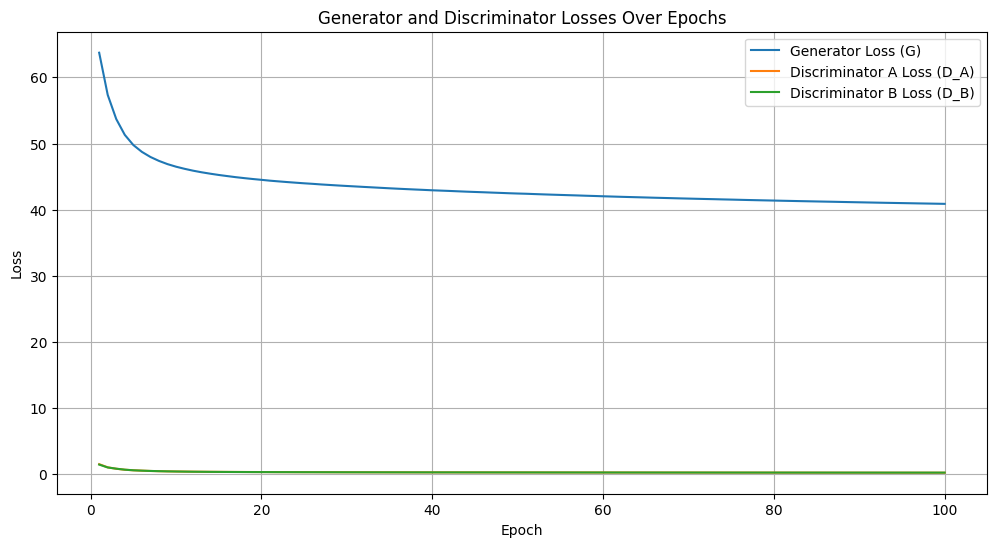

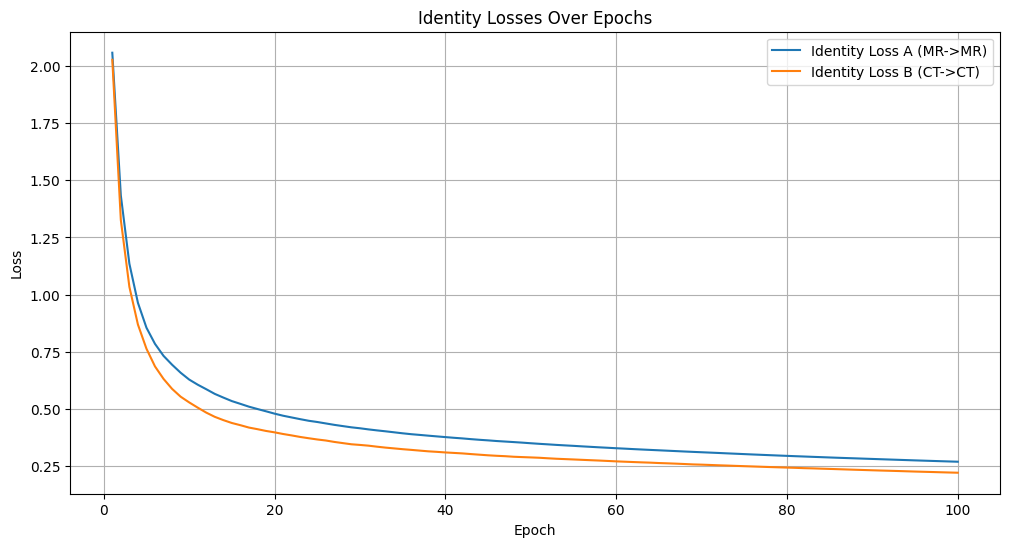

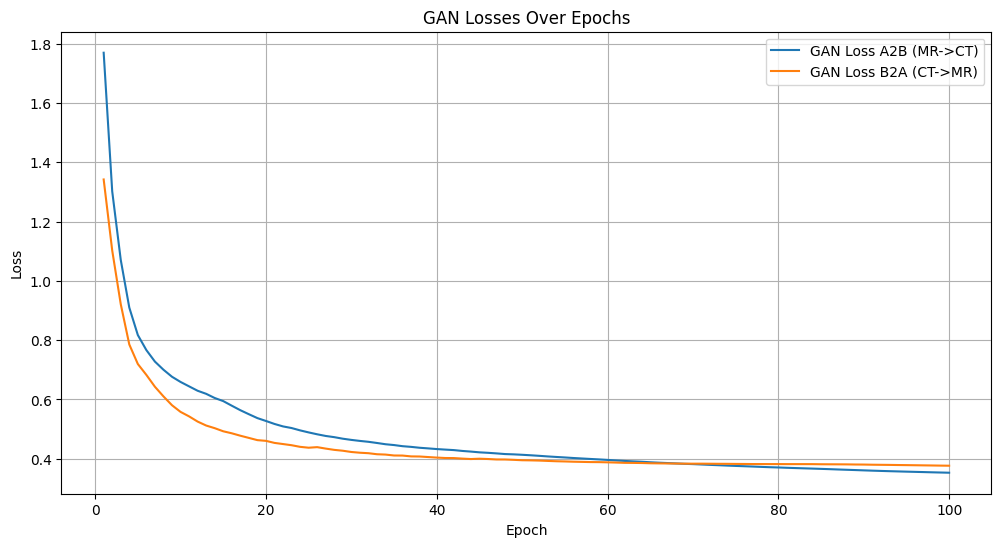

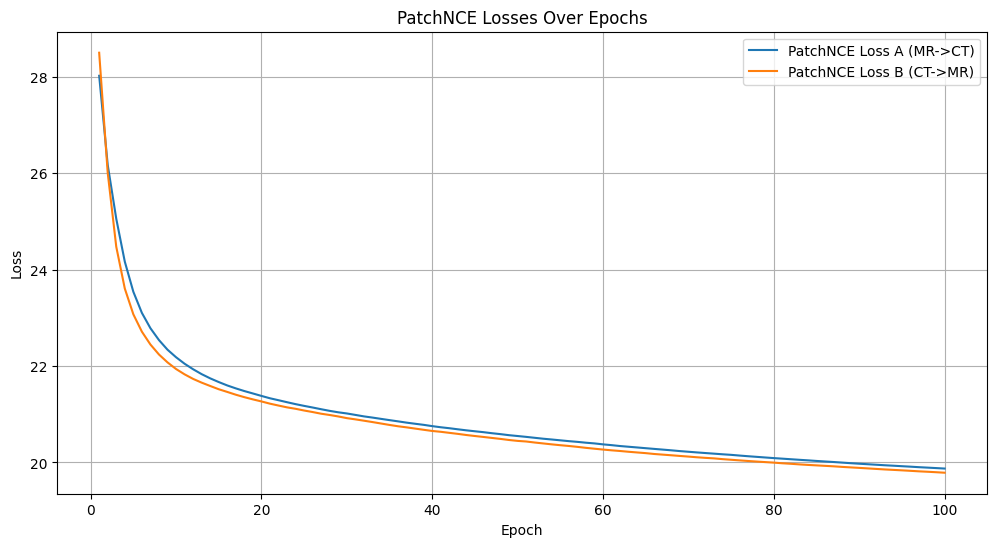

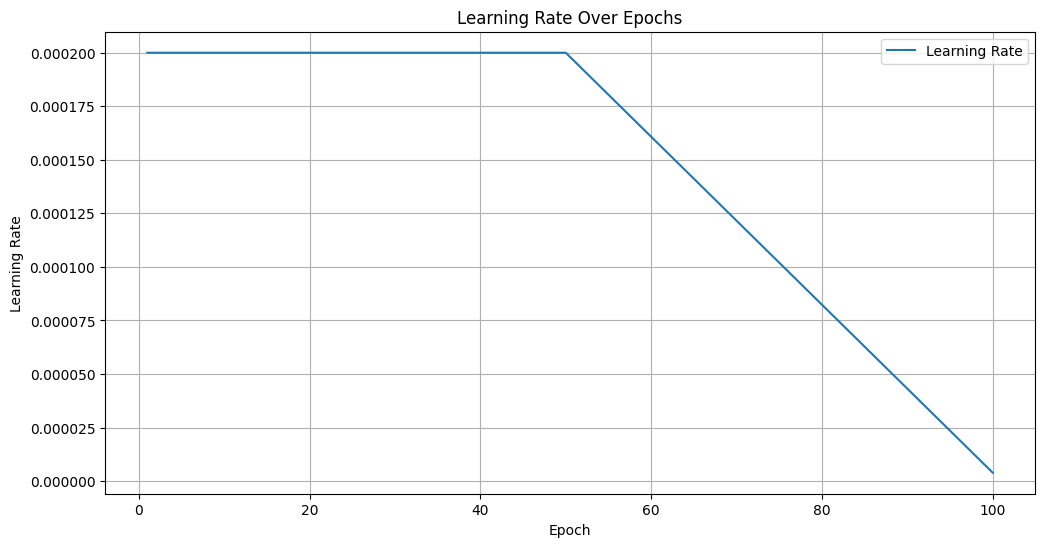

In [25]:
# Load & plot metrics
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure OUT_DIR matches the CUT code
OUT_DIR = '/kaggle/working/cut_outputs'
metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')

# --- 1. Load metrics CSV ---
try:
    # Ensure the directory exists for saving plots
    os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)
    metrics_df = pd.read_csv(metrics_csv)
    print(f"Metrics loaded successfully from: {metrics_csv}")
except FileNotFoundError:
    print(f"Error: metrics.csv not found at {metrics_csv}. Cannot generate plots.")
    # Exit the plotting part if the file is missing
    exit()

# ------------------------------------------------------------------
# --- 2. Plot Generator and Discriminator Losses ---
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_G'], label='Generator Loss (G)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_A'], label='Discriminator A Loss (D_A)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_B'], label='Discriminator B Loss (D_B)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'generator_discriminator_losses.png'), dpi=150)
plt.show() # Displays the plot

# ------------------------------------------------------------------
# --- 3. Plot Identity Losses ---
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_id_A'], label='Identity Loss A (MR->MR)')
plt.plot(metrics_df['epoch'], metrics_df['loss_id_B'], label='Identity Loss B (CT->CT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Identity Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'identity_losses.png'), dpi=150)
plt.show() # Displays the plot

# ------------------------------------------------------------------
# --- 4. Plot GAN Losses ---
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_A2B'], label='GAN Loss A2B (MR->CT)')
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_B2A'], label='GAN Loss B2A (CT->MR)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'gan_losses.png'), dpi=150)
plt.show() # Displays the plot

# ------------------------------------------------------------------
# --- 5. Plot PatchNCE Losses (replacing Cycle Consistency Losses) ---
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_patchnce_A'], label='PatchNCE Loss A (MR->CT)')
plt.plot(metrics_df['epoch'], metrics_df['loss_patchnce_B'], label='PatchNCE Loss B (CT->MR)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PatchNCE Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'patchnce_losses.png'), dpi=150)
plt.show() # Displays the plot

# ------------------------------------------------------------------
# --- 6. Plot Learning Rate ---
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'learning_rate.png'), dpi=150)
plt.show() 

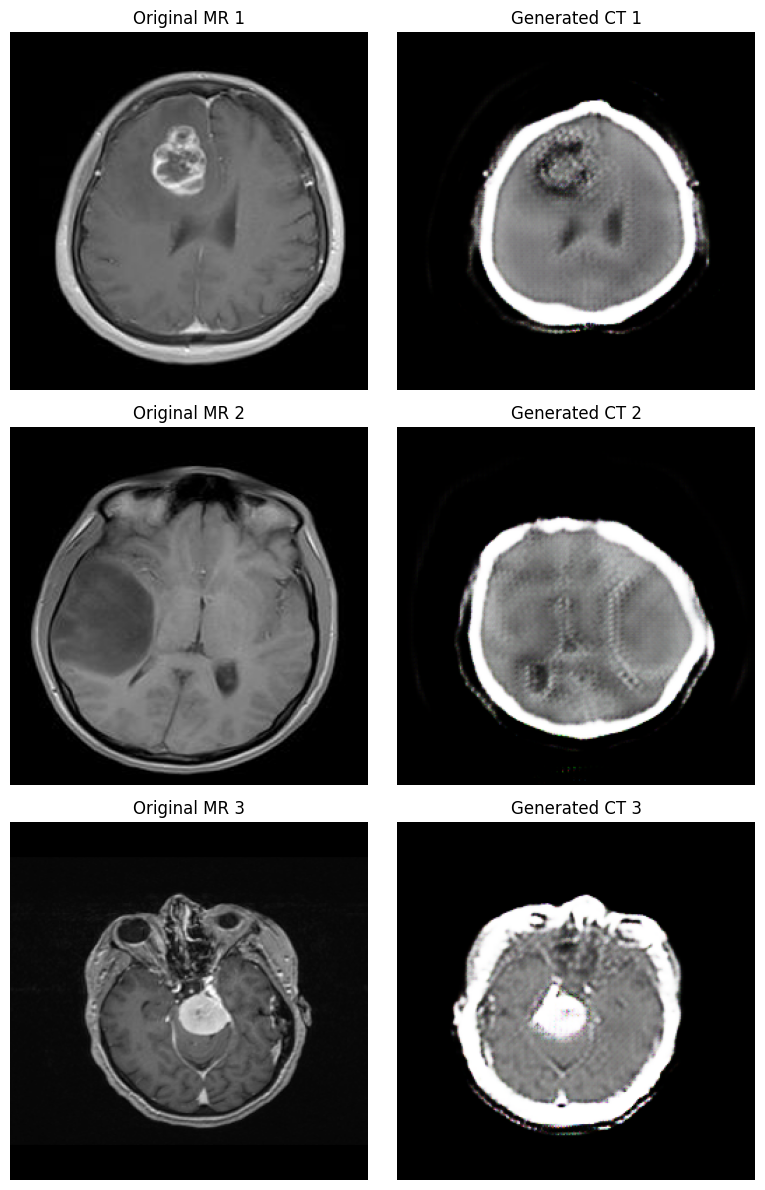

Saved CUT sample pairs to /kaggle/working/cut_outputs/plots/cut_sample_pairs.png


In [26]:
# ---------- Sample Visualization (CUT: A->B) ----------
import glob
from PIL import Image

# Generated folder (A2B only in CUT)
gen_folder = os.path.join(OUT_DIR, 'generated_A2B')

# Pick sample MR inputs
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
n_show = min(3, len(mr_paths))
idxs = [0, len(mr_paths)//2, len(mr_paths)-1][:n_show]
selected = [mr_paths[i] for i in idxs]

fig, axs = plt.subplots(n_show, 2, figsize=(8, 4 * n_show))

for i, mr_p in enumerate(selected):
    # Original MR
    mr_img = dcm_to_pil(mr_p).resize((IMAGE_SIZE, IMAGE_SIZE))

    # Find corresponding generated CT
    base = os.path.basename(mr_p).replace('.dcm', '.png')
    gen_p = os.path.join(gen_folder, base)
    if not os.path.exists(gen_p):
        print(f"Missing generated file for {base}, skipping...")
        continue

    gen_img = Image.open(gen_p).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))

    ax_left = axs[i, 0] if n_show > 1 else axs[0]
    ax_right = axs[i, 1] if n_show > 1 else axs[1]
    ax_left.imshow(mr_img, cmap='gray')
    ax_left.set_title(f'Original MR {i+1}')
    ax_left.axis('off')
    ax_right.imshow(gen_img)
    ax_right.set_title(f'Generated CT {i+1}')
    ax_right.axis('off')

plt.tight_layout()
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)
save_path = os.path.join(OUT_DIR, 'plots', 'cut_sample_pairs.png')
plt.savefig(save_path, dpi=150)
plt.show()
plt.close()

print(f'Saved CUT sample pairs to {save_path}')

In [27]:
# ---------- Saliency (XAI) for CUT ----------
def compute_saliency_cut(netG, netD, pil_img, transform):
    netG.eval()
    netD.eval()
    x = transform(pil_img).unsqueeze(0).to(device)
    x.requires_grad_(True)

    fake = netG(x)        # A -> B (CUT forward)
    pred = netD(fake)    # Discriminator score on generated
    score = pred.mean()

    netG.zero_grad()
    netD.zero_grad()
    score.backward()

    grad = x.grad.detach().cpu().squeeze()
    sal = grad.abs().max(0)[0].numpy()

    if sal.max() != sal.min():
        sal = (sal - sal.min()) / (sal.max() - sal.min())

    inp_vis = x.detach().cpu().squeeze()
    img_vis = ((inp_vis + 1.0) / 2.0).permute(1, 2, 0).numpy()
    return sal, img_vis

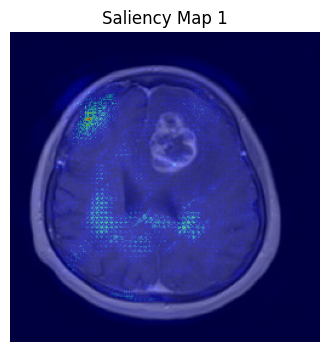

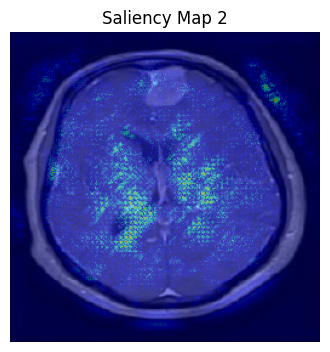

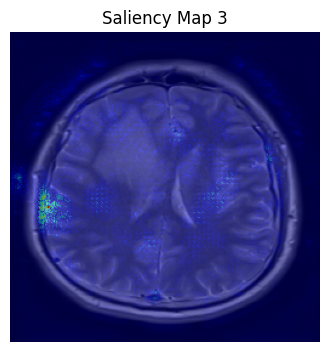

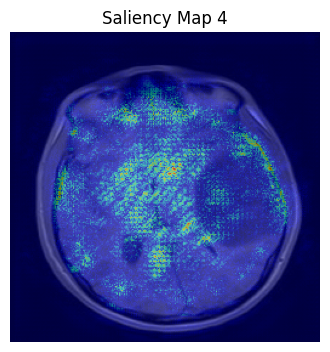

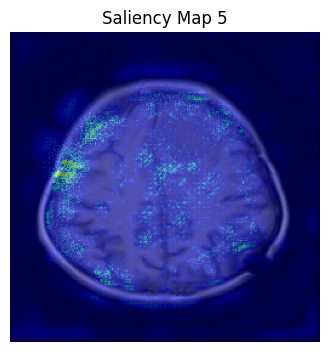

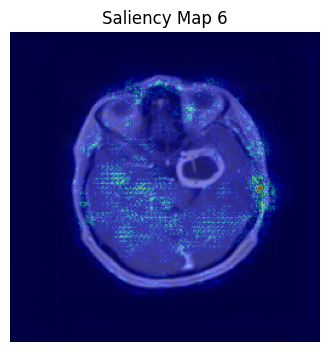

XAI Saliency maps generated and saved to /kaggle/working/cut_outputs/xai
XAI Insights: Saliency highlights input regions (bright colors) most influencing the CUT generator’s mapping from MR → CT, showing where the model focuses on key structures.


In [28]:
# ---------- Generate & Save Saliency Maps ----------
xai_folder = os.path.join(OUT_DIR, 'xai')
os.makedirs(xai_folder, exist_ok=True)

mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))
if len(mr_paths) > 0:
    n_show = min(6, len(mr_paths))  # Up to 6 for more insights
    step = max(1, len(mr_paths)//n_show)
    idxs = list(range(0, len(mr_paths), step))[:n_show]
    selected = [mr_paths[i] for i in idxs]

    for i, mr_p in enumerate(selected):
        pil_img = dcm_to_pil(mr_p)
        sal, img_vis = compute_saliency_cut(netG_A2B, netD_B, pil_img, transform)

        plt.figure(figsize=(4, 6))
        plt.imshow(img_vis, cmap='gray')
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title(f'Saliency Map {i+1}')
        save_path = os.path.join(xai_folder, f'saliency_{i:03d}.png')
        plt.savefig(save_path, dpi=150)
        plt.show()
        plt.close()

    print(f'XAI Saliency maps generated and saved to {xai_folder}')
    print('XAI Insights: Saliency highlights input regions (bright colors) most influencing the CUT generator’s mapping from MR → CT, showing where the model focuses on key structures.')
else:
    print('No MR DICOMs found for saliency generation.')

In [29]:
# GradCAM Class (same as before)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        all_modules = dict([*model.named_modules()])
        self.target_layer = all_modules[target_layer]
        self.gradients = None; self.activations = None; self.hook_handles = []
        self.hook_handles.append(self.target_layer.register_forward_hook(lambda m, i, o: self.forward_hook(o)))
        self.hook_handles.append(self.target_layer.register_backward_hook(lambda m, i, o: self.backward_hook(o)))
    def forward_hook(self, output): self.activations = output.detach()
    def backward_hook(self, grad_output): self.gradients = grad_output[0].detach()
    def remove_hooks(self): [h.remove() for h in self.hook_handles]
    def __call__(self, x):
        self.model.zero_grad(); output = self.model(x); score = output.mean(); score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True); cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze().cpu().numpy()
        if cam.max() - cam.min() > 1e-6: cam = (cam - cam.min()) / (cam.max() - cam.min())
        else: cam = np.zeros_like(cam)
        return cam
# GradCAM Overlay Utility
def overlay_heatmap_and_show(img_tensor, heatmap, save_path, title=None):
    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img_vis = (((img + 1.0) / 2.0) * 255).astype(np.uint8)
    if img_vis.ndim == 2: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    elif img_vis.shape[2] == 3: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_vis.shape[1], img_vis.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_vis, 0.6, heatmap_color, 0.4, 0)
    cv2.imwrite(save_path, overlay)
    plt.figure(figsize=(5, 5)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(title if title else "Grad-CAM Overlay"); plt.axis('off'); plt.show()

Attempting to generate XAI maps for 6 samples.
Generating Saliency and Grad-CAM for samples...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


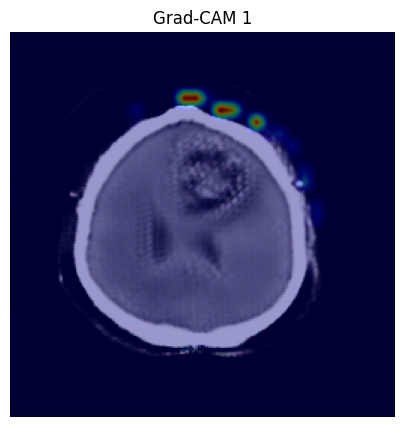

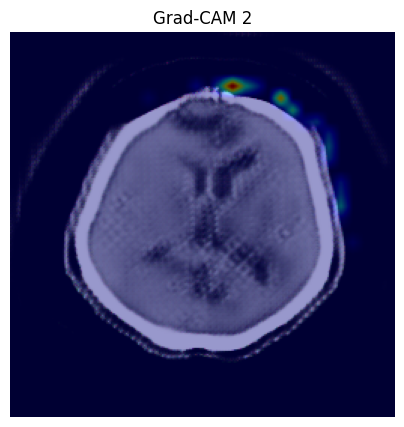

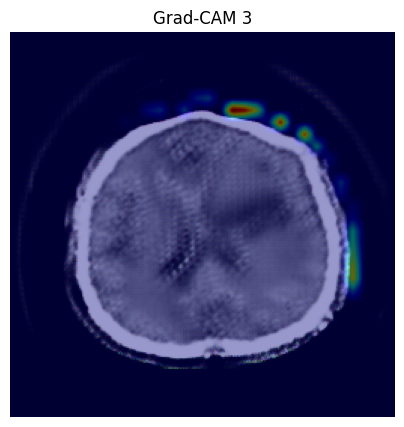

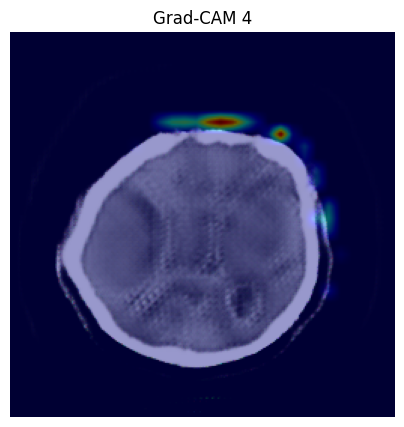

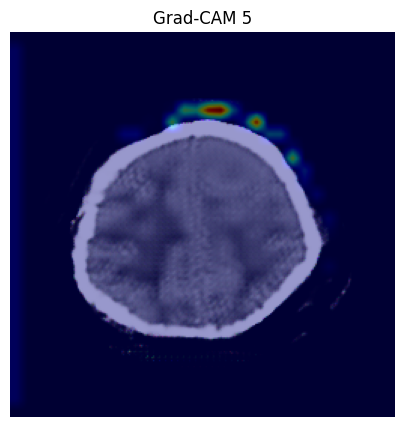

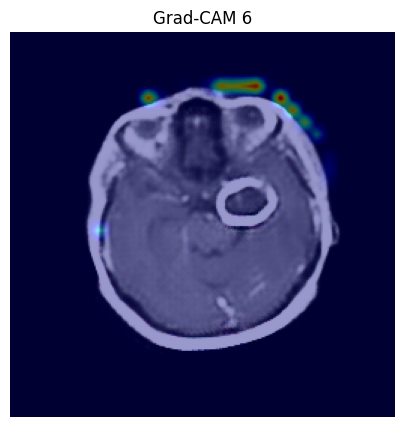

XAI maps generated and saved to /kaggle/working/cut_outputs/xai and /kaggle/working/cut_outputs/xai_gradcam


In [30]:
# XAI: Run Saliency and Grad-CAM
xai_folder = os.path.join(OUT_DIR, 'xai'); os.makedirs(xai_folder, exist_ok=True); os.makedirs(os.path.join(OUT_DIR, "xai_gradcam"), exist_ok=True)
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, '*.dcm')))

# --- CHANGE 1: Set the desired number of samples (up to 6) ---
n_show = min(6, len(mr_paths)) 

# --- CHANGE 2: Update indexing logic to select n_show samples evenly ---
# Calculate the step size to select up to 6 images evenly distributed
step = max(1, len(mr_paths) // n_show)
idxs = list(range(0, len(mr_paths), step))[:n_show] 

selected = [mr_paths[i] for i in idxs]
print(f"Attempting to generate XAI maps for {len(selected)} samples.")

try:
    netG_A2B.eval(); netD_B.eval()
    gradcam = GradCAM(netD_B, target_layer='model.7')
    print("Generating Saliency and Grad-CAM for samples...")
    for i, mr_p in enumerate(selected):
        pil_img = dcm_to_pil(mr_p)

        # # Saliency
        # sal, img_vis = compute_saliency_cut(netG_A2B, netD_B, pil_img, transform)  
        # plt.figure(figsize=(4, 6)); plt.imshow(img_vis, cmap='gray'); plt.imshow(sal, cmap='jet', alpha=0.5)
        # plt.title(f'Saliency Map {i+1}'); plt.axis('off'); plt.savefig(os.path.join(xai_folder, f'saliency_{i:03d}.png')); plt.show(); plt.close()
        
        # Grad-CAM
        sample_A = transform(pil_img).unsqueeze(0).to(device)
        with torch.no_grad(): fake_translated = netG_A2B(sample_A)
        cam_map = gradcam(fake_translated)
        overlay_heatmap_and_show(fake_translated, cam_map, os.path.join(OUT_DIR, "xai_gradcam", f"gradcam_fake_{i+1}.png"), title=f"Grad-CAM {i+1}")
        
    gradcam.remove_hooks()
    print(f'XAI maps generated and saved to {xai_folder} and {os.path.join(OUT_DIR, "xai_gradcam")}')
except Exception as e:
    print(f"XAI visualization failed: {e}")

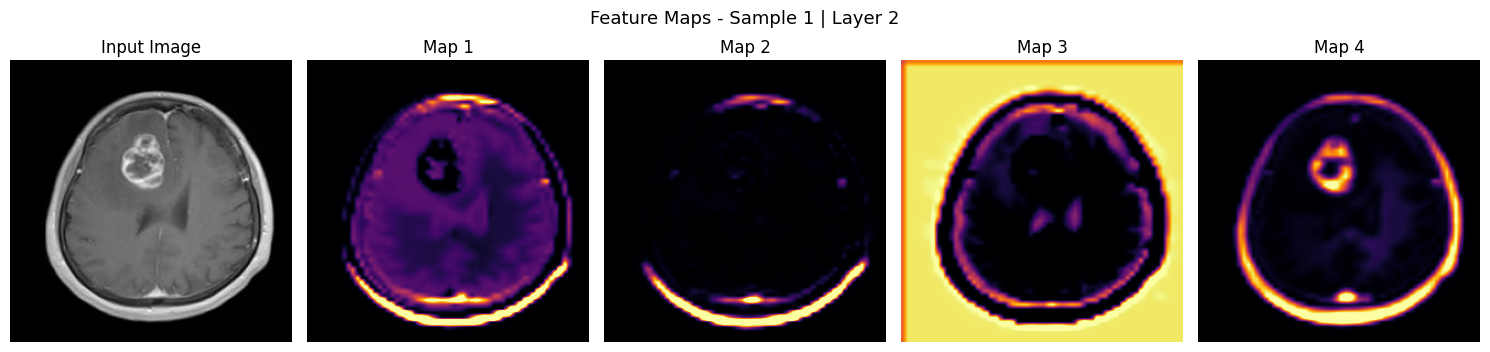

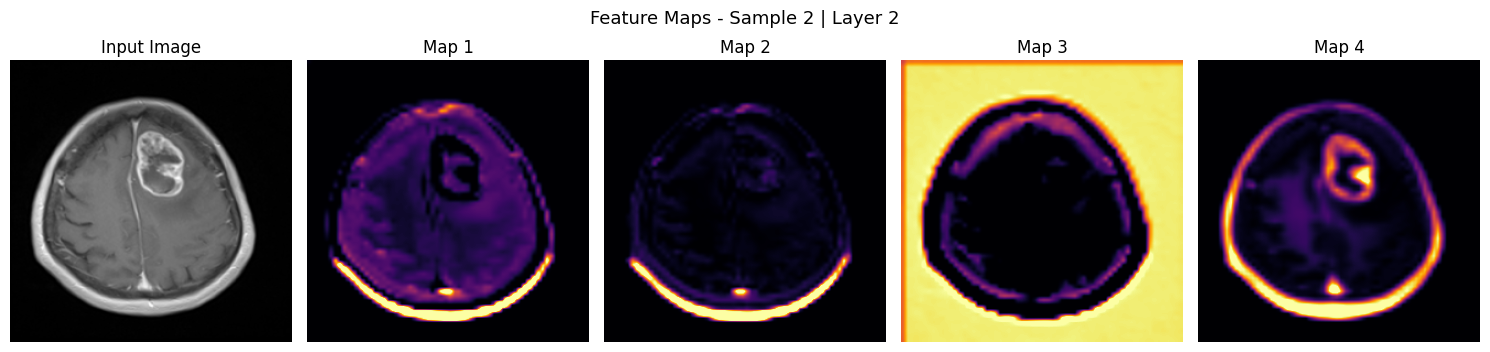

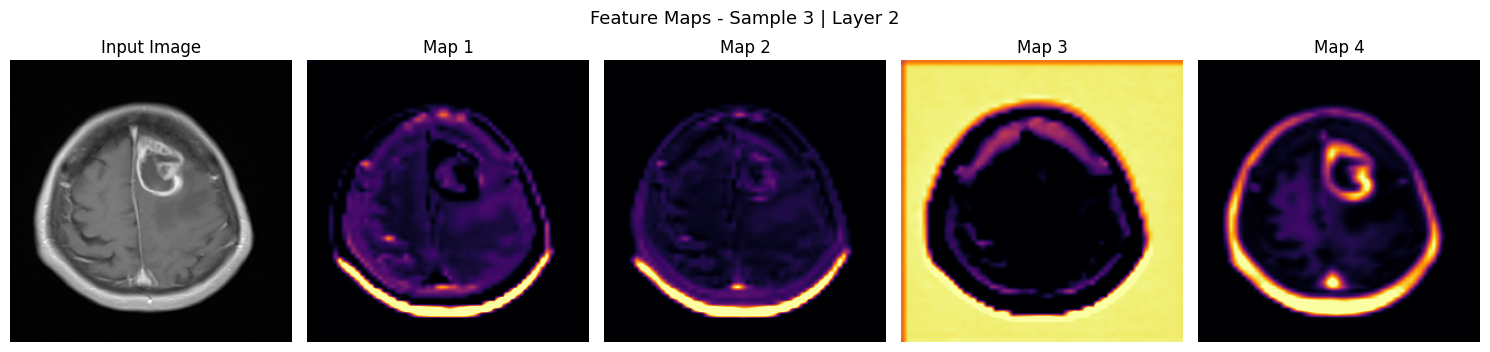

Feature maps saved in: /kaggle/working/cut_outputs/xai_featuremaps


In [31]:
def visualize_feature_maps(netG_A2B, real_A, device, num_samples=3, layer_index=3, save_dir='feature_maps', upsample_to=256):
    """Improved visualization of feature maps with upsampling and normalization."""
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    def get_activation(name):
        return lambda m, i, o: activation.update({name: o.detach()})

    # Attach hook
    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    with torch.no_grad():
        for i in range(min(num_samples, real_A.size(0))):
            G_input = real_A[i].unsqueeze(0).to(device)
            _ = netG_A2B(G_input)

            fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)  # (C,H,W)
            if upsample_to:
                fmap = F.interpolate(fmap.unsqueeze(0), size=(upsample_to, upsample_to), mode='bilinear', align_corners=False).squeeze(0)

            n_show = min(4, fmap.shape[0])
            fig, axes = plt.subplots(1, n_show + 1, figsize=(15, 4))

            # Original image
            inp = ((G_input.squeeze().cpu().permute(1,2,0) + 1) / 2).numpy()
            inp = np.clip(inp, 0, 1)
            axes[0].imshow(inp)
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Feature maps
            for j in range(n_show):
                f = fmap[j].numpy()
                # Normalize with percentile clipping
                lo, hi = np.percentile(f, (2, 98))
                f = np.clip((f - lo) / (hi - lo + 1e-5), 0, 1)
                axes[j+1].imshow(f, cmap='inferno')
                axes[j+1].set_title(f"Map {j+1}")
                axes[j+1].axis('off')

            plt.tight_layout()
            fig.suptitle(f"Feature Maps - Sample {i+1} | Layer {layer_index}", fontsize=13)

            save_path = os.path.join(save_dir, f"sample_{i+1}_layer_{layer_index}.png")
            plt.savefig(save_path, bbox_inches='tight')
            plt.show()
            plt.close(fig)

    hook_handle.remove()
    print(f"Feature maps saved in: {save_dir}")

# Example run
try:
    dataloader_val = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
    real_A_sample = next(iter(dataloader_val))["A"]
    visualize_feature_maps(netG_A2B, real_A_sample, device, num_samples=3, layer_index=2, save_dir=os.path.join(OUT_DIR, "xai_featuremaps"))
except Exception as e:
    print(f"Feature Map visualization failed: {e}")
